In [1]:
# Set-up
%matplotlib inline
import matplotlib.pyplot as plt

# Built-in python modules
import math
import datetime
import warnings
warnings.filterwarnings(action='ignore')

# Python add-ons
import numpy as np
import pandas as pd
from statsmodels.api import qqplot

# Sandia pvlib-python
import pvlib

# Synthetic
import sys
sys.path.insert(1, '../../')
import src

# 1. Data

In [2]:
FILE = 'tucson-30'

df = pd.read_csv(filepath_or_buffer=f'../data/{FILE}.csv', sep=',', decimal='.', index_col='timestamp', parse_dates=True)

# NaN
df = df.fillna(0)

# Ant data
df.loc[df['ghi_wm2'] <= 1.5, 'ghi_wm2'] = 0

# 2. Synthetic Irradiance Data Generation

## 2.1. Clear-Sky Index

In [3]:
# Location
latitude = 33.45
longitude = -112.06
tz = 'America/Phoenix'
altitude = 680 # [m]

location = pvlib.location.Location(latitude, longitude, tz, altitude)

In [4]:
# Clear-sky irradiance (Hcs)
RESOLUTION = int(pd.Series(df.index.values).diff().median().total_seconds()/60)

hcs = location.get_clearsky(times=pd.date_range(start=df.index[0] - datetime.timedelta(days=1, hours=0, minutes=0),
                                                end=df.index[-1] + datetime.timedelta(days=1, hours=6, minutes=0),
                                                freq=f'{RESOLUTION}min',
                                                tz=None),
                            model='ineichen')

In [5]:
# Append clear-sky irradiance to main dataframe
df = pd.merge(df, hcs['ghi'], left_index=True, right_index=True)
df = df.rename(columns={'ghi': 'hcs_wm2'})

# Clear-sky index (kc) to main dataframe
df['kc'] = df['ghi_wm2'].values / df['hcs_wm2'].values

# Filters
## NaN
df['kc'] = df['kc'].fillna(1)

# Replace kc > 1
df.loc[df['kc'] > 1, 'kc'] = 1

# Time zone adjustment
df.index = df.index - datetime.timedelta(days=0, hours=7, minutes=0)

aux = df.iloc[0:7*2]
aux.index = aux.index + datetime.timedelta(days=365)
df = pd.concat([df.iloc[7*2::], aux])

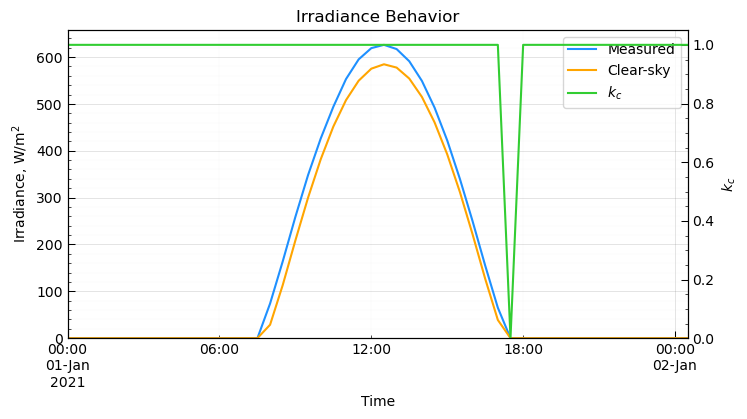

In [6]:
hor = 8
ver = 4
plt.figure(figsize=(hor, ver), dpi=100)

# GHI and Hcs
df['ghi_wm2'][0:50].plot(color='dodgerblue', label='Measured', xlabel='Time', ylabel='Irradiance, W/m$^2$', legend=True)
df['hcs_wm2'][0:50].plot(color='orange', label='Clear-sky', xlabel='Time', ylabel='Irradiance, W/m$^2$', legend=True)

plt.rcParams['axes.axisbelow'] = True

plt.title('Irradiance Behavior')
plt.xlabel('Time')

plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.minorticks_on()
plt.ylim(0, None)
plt.xlim(None, None)
plt.grid(True)
plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
plt.legend(loc='best', fontsize=9)
plt.tight_layout;

# kc
df['kc'][0:50].plot(color='limegreen', label='$k_c$', secondary_y=True, xlabel='Time', ylabel='$k_c$', legend=True, mark_right=False)

plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.minorticks_on()
plt.ylim(0, None)
plt.xlim(None, None)
plt.tight_layout;

## 2.2. `analysis`: Function to extract descriptive statistics from irradiance data

In [7]:
TIMES = [f'{i}:0{j}' if j < 10 else f'{i}:{j}' for i in range(0, 24) for j in range(0, 60, RESOLUTION)]

MONTHS = {'1': 'Jan', '2': 'Feb', '3': 'Mar', '4': 'Apr', '5': 'May', '6': 'Jun',
          '7': 'Jul', '8': 'Aug', '9': 'Sep', '10': 'Oct', '11': 'Nov', '12': 'Dec'}

INVERSE_MONTHS = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
                  'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

MULTIINDEX = [(i,j) for i in range(0, 24) for j in range(0, 60, 5)]

XTICKS = np.arange(start=0, stop=len(TIMES), step=50)
LABELS = [TIMES[i] for i in XTICKS]

### 2.2.1. Shapiro-Wilk, Anderson-Darling and Kolmogorov-Smirnov tests

In [8]:
LOOP_YEARS = df.index.year.unique().values
LOOP_MONTHS = df.index.month.unique().values
LOOP_SC = ['sc1', 'sc2', 'sc3', 'sc4', 'sc5']

LOOP_ANALYSIS = {}

for i in LOOP_YEARS:
    for j in LOOP_MONTHS:
        LOOP_ANALYSIS[f'{MONTHS[str(j)]}{i}'] = src.utils.analysis(df=df, year=i, month=j, irradiance_column='ghi_wm2', resolution=RESOLUTION, plot=False)

In [9]:
# For high resolution (e.g., 5 min), this cell takes ~10 min to run

DISTRIBUTIONS = pd.DataFrame()

for z in LOOP_ANALYSIS.keys():
    i = int(z[3:7]) # Year
    j = INVERSE_MONTHS[z[0:3]] # Month

    for k in LOOP_SC:
        df_to_check = LOOP_ANALYSIS[z]['bootstrap'][k]

        if (df_to_check.empty != True) and (len(df_to_check) >= 3):
            aux_df = pd.DataFrame(data={'year':i,
                                        'month': j,
                                        'sc': k,
                                        'shapiro_wilk': [src.utils.shapiro_wilk(data=d) for d in df_to_check.T.values],
                                        'anderson_darling': [src.utils.anderson_darling(data=d) for d in df_to_check.T.values],
                                        'lognormal_test': [src.utils.lognormal_test(data=d) for d in df_to_check.T.values]},
                                  index=df_to_check.columns).iloc[TIMES.index('6:00'):TIMES.index('18:00'),:] # 6:15 to 17:45h

            DISTRIBUTIONS = pd.concat([DISTRIBUTIONS, aux_df])

DISTRIBUTIONS.to_csv(f'../distributions/{FILE}/distributions.csv')

DISTRIBUTIONS.describe()

,year,month,shapiro_wilk,anderson_darling,lognormal_test
count,336.0,336.000000,336.000000,336.000000,336.000000
mean,2021.0,6.571429,0.127470,0.955357,0.079494
std,0.0,3.205539,0.273617,0.206826,0.191044
min,2021.0,1.000000,0.000000,0.000000,0.000000
25%,2021.0,4.000000,0.000000,1.000000,0.000000
50%,2021.0,7.000000,0.000000,1.000000,0.000000
75%,2021.0,9.000000,0.060000,1.000000,0.000000
max,2021.0,12.000000,1.000000,1.000000,1.000000


In [10]:
# Gaussian distribution
complete_gaussian = (len(DISTRIBUTIONS[(DISTRIBUTIONS['shapiro_wilk'] > 0.05) & (DISTRIBUTIONS['anderson_darling'] == 1)]) / len(DISTRIBUTIONS)) * 100
print(f'{np.round(a=complete_gaussian, decimals=2)}% of the total data behaves as a Gaussian distribution according to Shapiro-Wilk and Anderson-Darling tests.')

# Lognormal distribution
complete_lognormal = (len(DISTRIBUTIONS[(DISTRIBUTIONS['lognormal_test'] > 0.05)]) / len(DISTRIBUTIONS)) * 100
print(f'{np.round(a=complete_lognormal, decimals=2)}% of the total data behaves as a lognormal distribution.')

# Gaussian or lognormal
gaussian_or_lognormal = (len(DISTRIBUTIONS[((DISTRIBUTIONS['shapiro_wilk'] > 0.05) & (DISTRIBUTIONS['anderson_darling'] == 1)) | (DISTRIBUTIONS['lognormal_test'] > 0.05)]) / len(DISTRIBUTIONS)) * 100
print(f'{np.round(a=gaussian_or_lognormal, decimals=2)}% of the total data behaves either Gaussian or lognormal distribution.')

20.83% of the total data behaves as a Gaussian distribution according to Shapiro-Wilk and Anderson-Darling tests.
19.05% of the total data behaves as a lognormal distribution.
27.08% of the total data behaves either Gaussian or lognormal distribution.


In [11]:
GROUPED_DISTRIBUTIONS = DISTRIBUTIONS.groupby(by=['year', 'month', 'sc']).mean().round(decimals=2).astype({'anderson_darling': int})
GROUPED_DISTRIBUTIONS.to_csv(f'../distributions/{FILE}/grouped.csv')

GROUPED_DISTRIBUTIONS.describe()

,shapiro_wilk,anderson_darling,lognormal_test
count,14.000000,14.000000,14.000000
mean,0.127143,0.500000,0.080000
std,0.137305,0.518875,0.093972
min,0.010000,0.000000,0.000000
25%,0.030000,0.000000,0.022500
50%,0.090000,0.500000,0.040000
75%,0.140000,1.000000,0.110000
max,0.440000,1.000000,0.320000


In [12]:
# Gaussian distribution
grouped_gaussian = (len(GROUPED_DISTRIBUTIONS[(GROUPED_DISTRIBUTIONS['shapiro_wilk'] > 0.05) & (GROUPED_DISTRIBUTIONS['anderson_darling'] == 1)]) / len(GROUPED_DISTRIBUTIONS)) * 100
print(f'{np.round(a=grouped_gaussian, decimals=2)}% of the total data behaves as a Gaussian distribution according to Shapiro-Wilk and Anderson-Darling tests.')

# Lognormal distribution
grouped_lognormal = (len(GROUPED_DISTRIBUTIONS[(GROUPED_DISTRIBUTIONS['lognormal_test'] > 0.05)]) / len(GROUPED_DISTRIBUTIONS)) * 100
print(f'{np.round(a=grouped_lognormal, decimals=2)}% of the total data behaves as a lognormal distribution.')

# Gaussian or lognormal
grouped_gaussian_or_lognormal = (len(GROUPED_DISTRIBUTIONS[((GROUPED_DISTRIBUTIONS['shapiro_wilk'] > 0.05) & (GROUPED_DISTRIBUTIONS['anderson_darling'] == 1)) | (GROUPED_DISTRIBUTIONS['lognormal_test'] > 0.05)]) / len(GROUPED_DISTRIBUTIONS)) * 100
print(f'{np.round(a=grouped_gaussian_or_lognormal, decimals=2)}% of the total data behaves either Gaussian or lognormal distribution.')

21.43% of the total data behaves as a Gaussian distribution according to Shapiro-Wilk and Anderson-Darling tests.
42.86% of the total data behaves as a lognormal distribution.
42.86% of the total data behaves either Gaussian or lognormal distribution.


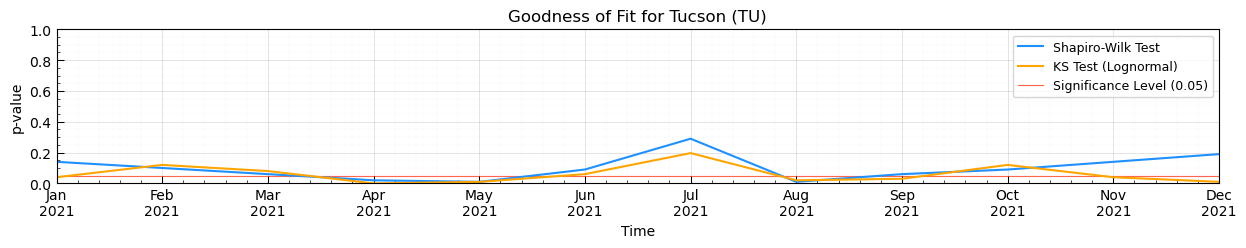

In [13]:
aux_grouped_distributions = GROUPED_DISTRIBUTIONS.groupby(['year', 'month']).mean()
x_axis = [f'{MONTHS[str(i[1])]}\n{i[0]}' for i in aux_grouped_distributions.index]

XTICKS = np.arange(start=0, stop=len(x_axis), step=1)
LABELS = [x_axis[i] for i in XTICKS]

hor = 15
ver = 2
plt.figure(figsize=(hor,ver), dpi=100)

plt.plot(aux_grouped_distributions['shapiro_wilk'].values, color='dodgerblue', label='Shapiro-Wilk Test')
plt.plot(aux_grouped_distributions['lognormal_test'].values, color='orange', label='KS Test (Lognormal)')
plt.axhline(y=0.05, linewidth=0.8, color='tomato', label='Significance Level (0.05)', zorder=0)

plt.title(f'Goodness of Fit for Tucson (TU)')
plt.ylabel('p-value')
plt.xlabel('Time')
plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0, ticks=XTICKS, labels=LABELS)
plt.minorticks_on()
plt.ylim(0, 1)
plt.xlim(0, len(aux_grouped_distributions)-1)
plt.grid(True)
plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
plt.tight_layout
plt.legend(loc='best', fontsize=9) # bbox_to_anchor=(1,1)

### 2.2.2. Histogram (Gaussian or lognormal distributions)

In [14]:
# Constants
TIMES = [f'{i}:0{j}' if j < 10 else f'{i}:{j}' for i in range(0, 24) for j in range(0, 60, RESOLUTION)]

MONTHS = {'1': 'Jan', '2': 'Feb', '3': 'Mar', '4': 'Apr', '5': 'May', '6': 'Jun',
          '7': 'Jul', '8': 'Aug', '9': 'Sep', '10': 'Oct', '11': 'Nov', '12': 'Dec'}

XTICKS = np.arange(start=0, stop=len(TIMES), step=10)
LABELS = [TIMES[i] for i in XTICKS]

# src.utils.analysis function example
YEAR = 2021
MONTH = 1

ANALYSIS = src.utils.analysis(df=df, year=YEAR, month=MONTH, irradiance_column='ghi_wm2', resolution=RESOLUTION, plot=False)

<Figure size 800x500 with 0 Axes>

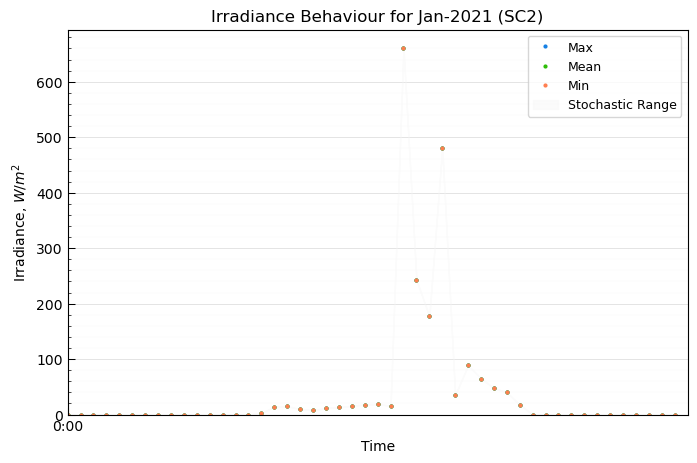

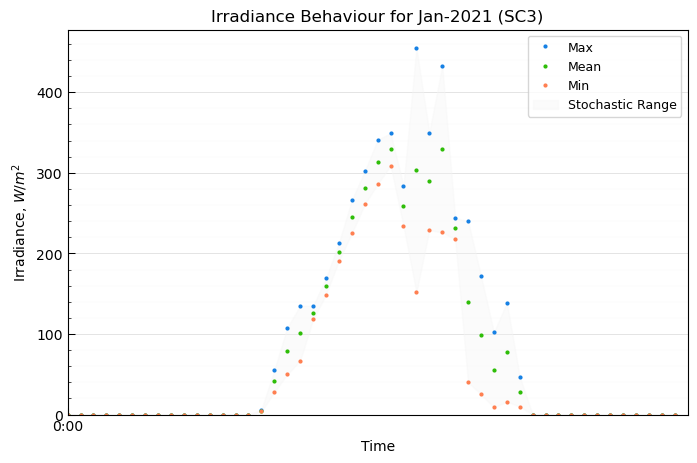

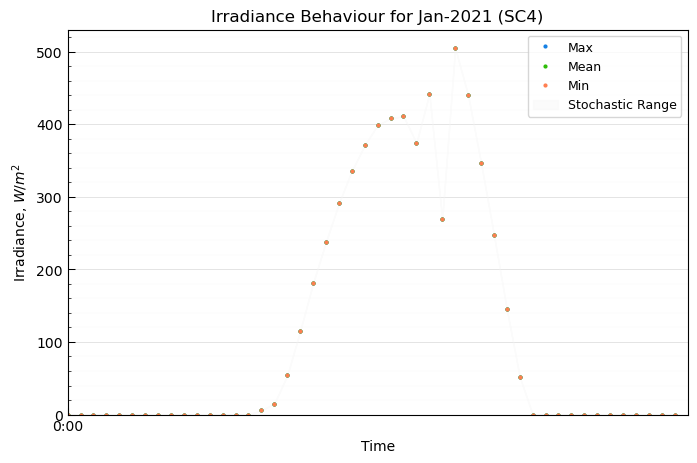

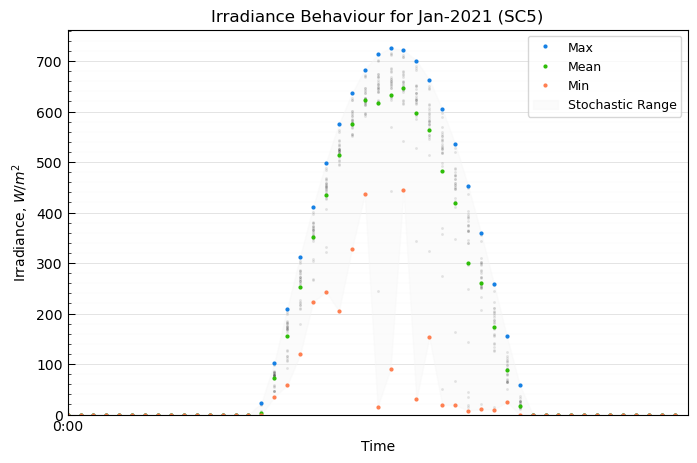

In [15]:
# Constants
TIMES = [f'{i}:0{j}' if j < 10 else f'{i}:{j}' for i in range(0, 24) for j in range(0, 60, RESOLUTION)]

MONTHS = {'1': 'Jan', '2': 'Feb', '3': 'Mar', '4': 'Apr', '5': 'May', '6': 'Jun',
          '7': 'Jul', '8': 'Aug', '9': 'Sep', '10': 'Oct', '11': 'Nov', '12': 'Dec'}

XTICKS = np.arange(start=0, stop=len(TIMES), step=10)
LABELS = [TIMES[i] for i in XTICKS]

# src.utils.analysis function example
YEAR = 2021
MONTH = 1

ANALYSIS = src.utils.analysis(df=df, year=YEAR, month=MONTH, irradiance_column='ghi_wm2', resolution=RESOLUTION, plot=True)

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

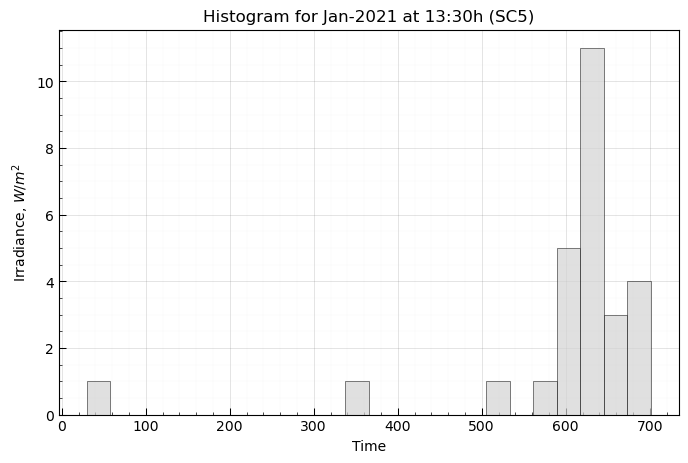

In [16]:
HOUR = 13
MINUTE = 30
SC = 'sc5'

df_to_hist = df[(df.index.year == YEAR) & (df.index.month == MONTH) & (df.index.day.isin(ANALYSIS['bootstrap'][SC].index)) & (df.index.hour == HOUR) & (df.index.minute == MINUTE)]['ghi_wm2'].values

hor = 8
ver = 5
plt.figure(figsize=(hor,ver))

plt.hist(x=df_to_hist, bins='auto', color='lightgrey', alpha=0.7, edgecolor='black', linewidth=0.5);

plt.title(f'Histogram for {MONTHS[str(MONTH)]}-{YEAR} at {HOUR}:{MINUTE}h ({str.upper(SC)})')
plt.ylabel('Irradiance, $W/m^2$')
plt.xlabel('Time')
plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.minorticks_on()
plt.ylim(0, None)
plt.xlim(None, None)
plt.grid(True)
plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
plt.tight_layout
#plt.legend(loc='best', fontsize=9) # bbox_to_anchor=(1,1)

### 2.2.3. QQ-Plots

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

<Figure size 800x500 with 0 Axes>

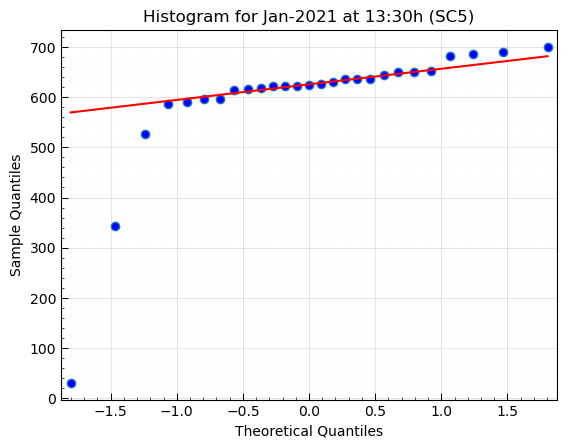

In [17]:
hor = 8
ver = 5
plt.figure(figsize=(hor,ver))

qqplot(df_to_hist, line='q', markerfacecolor='blue')

plt.title(f'Histogram for {MONTHS[str(MONTH)]}-{YEAR} at {HOUR}:{MINUTE}h ({str.upper(SC)})')
#plt.ylabel()
#plt.xlabel()
plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.minorticks_on()
plt.ylim(None, None)
plt.xlim(None, None)
plt.grid(True)
plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
plt.tight_layout
#plt.legend(loc='best', fontsize=9) # bbox_to_anchor=(1,1)

# 3. Validations

In [18]:
SYNTHETIC = {'stochastic': {}, 'bootstrap': {}}
IC = 0.95
RUNS = 10

for i in LOOP_YEARS:
    for j in LOOP_MONTHS:
        for k in LOOP_SC:
            # Stochastic
            SYNTHETIC['stochastic'][f'{MONTHS[str(j)]}{i}-{k}'] = src.methods.autoregressive(data=df,
                                                                                             irradiance_column='ghi_wm2',
                                                                                             year=i,
                                                                                             month=j,
                                                                                             sky_condition=k,
                                                                                             method='stochastic',
                                                                                             IC=IC,
                                                                                             resolution=RESOLUTION,
                                                                                             runs=RUNS)
            # Bootstrap
            SYNTHETIC['bootstrap'][f'{MONTHS[str(j)]}{i}-{k}'] = src.methods.autoregressive(data=df,
                                                                                            irradiance_column='ghi_wm2',
                                                                                            year=i,
                                                                                            month=j,
                                                                                            sky_condition=k,
                                                                                            method='bootstrap',
                                                                                            IC=IC,
                                                                                            resolution=RESOLUTION,
                                                                                            runs=RUNS)

## 3.1. Variability metrics

In [19]:
VARIABILITY_METRICS = {'stochastic': {}, 'bootstrap': {}}
RUNS = 100

for m in ['stochastic', 'bootstrap']:
    for z in SYNTHETIC[m].keys():
        i = int(z[3:7]) # Year
        j = INVERSE_MONTHS[z[0:3]] # Month
        k = z[8:11] # Sky condition

        metrics = {'standard_deviation_increments': [[], []],
                    'stability_index': [[], []],
                    'iccdf': [[], []],
                    'variability_index': [[], []]}

        for _ in range(RUNS):
            try:
                aux = LOOP_ANALYSIS[f'{MONTHS[str(j)]}{i}']['bootstrap'][k].T.sample(n=1, axis=1)
                sample1 = aux.values.flatten()
                sample2 = SYNTHETIC[m][f'{MONTHS[str(j)]}{i}-{k}'].sample(n=1, axis=1).values.flatten()

                # Standard deviation of increments (SDI)
                metrics['standard_deviation_increments'][0].append(src.metrics.standard_deviation_increments(data=sample1))
                metrics['standard_deviation_increments'][1].append(src.metrics.standard_deviation_increments(data=sample2))

                # Stability index (SI)
                metrics['stability_index'][0].append(src.metrics.stability_index(data=sample1, threshold=100))
                metrics['stability_index'][1].append(src.metrics.stability_index(data=sample2, threshold=100))

                # Integrated complementary cumulative distribution function (ICCDF)
                metrics['iccdf'][0].append(src.metrics.iccdf(data=sample1))
                metrics['iccdf'][1].append(src.metrics.iccdf(data=sample2))

                # Variability index (VI)
                temp = df.loc[(df.index.year == i) & (df.index.month == j) & (df.index.day == aux.columns[0])]
                metrics['variability_index'][0].append(src.metrics.variability_index(timestamps=temp.index, ghi=sample1, hcs=temp['hcs_wm2'].values).mean())
                metrics['variability_index'][1].append(src.metrics.variability_index(timestamps=temp.index, ghi=sample2, hcs=temp['hcs_wm2'].values).mean())

            except:
                pass

        for _ in metrics.keys():
            metrics[_] = np.mean(metrics[_], axis=1)

        VARIABILITY_METRICS[m][f'{MONTHS[str(j)]}{i}-{k}'] = metrics

In [20]:
metrics_stochastic = pd.DataFrame(VARIABILITY_METRICS['stochastic']).T
metrics_bootstrap = pd.DataFrame(VARIABILITY_METRICS['bootstrap']).T

# Stochastic
pe_stochastic = metrics_stochastic * 0
pe_stochastic['month'] = [INVERSE_MONTHS[i[0:3]] for i in pe_stochastic.index]
pe_stochastic['sc'] = [i[8:11] for i in pe_stochastic.index]

for i in metrics_stochastic.columns:
    pe_stochastic[i] = [src.metrics.wrapper_percentage_error(j) for j in metrics_stochastic[i]]

pe_stochastic = pe_stochastic.fillna(0)

# Bootstrap
pe_bootstrap = metrics_bootstrap * 0
pe_bootstrap['month'] = [INVERSE_MONTHS[i[0:3]] for i in pe_bootstrap.index]
pe_bootstrap['sc'] = [i[8:11] for i in pe_bootstrap.index]

for i in metrics_bootstrap.columns:
    pe_bootstrap[i] = [src.metrics.wrapper_percentage_error(j) for j in metrics_bootstrap[i]]

pe_bootstrap = pe_bootstrap.fillna(0)

In [21]:
# Percentage error monthly average
VM_STOCHASTIC_MONTH = pe_stochastic.groupby(by='month').mean().round(decimals=2)
VM_BOOTSTRAP_MONTH = pe_bootstrap.groupby(by='month').mean().round(decimals=2)

# Percentage error sky condition average
VM_STOCHASTIC_SC = pe_stochastic.groupby(by='sc').mean().round(decimals=2)
VM_BOOTSTRAP_SC = pe_bootstrap.groupby(by='sc').mean().round(decimals=2)

In [22]:
# Download
VM_STOCHASTIC_MONTH.to_csv(f'../metrics/variability/{FILE}/stochastic_month.csv')
VM_BOOTSTRAP_MONTH.to_csv(f'../metrics/variability/{FILE}/bootstrap_month.csv')
VM_STOCHASTIC_SC.to_csv(f'../metrics/variability/{FILE}/stochastic_sc.csv')
VM_BOOTSTRAP_SC.to_csv(f'../metrics/variability/{FILE}/bootstrap_sc.csv')

## 3.2. Comparison of statistical distributions

In [23]:
STATISTICAL_METRICS = {'stochastic': {}, 'bootstrap': {}}
RUNS = 100

for m in ['stochastic', 'bootstrap']:
    for z in SYNTHETIC[m].keys():
        i = int(z[3:7]) # Year
        j = INVERSE_MONTHS[z[0:3]] # Month
        k = z[8:11] # Sky condition

        metrics = {'kolmogorov_smirnov': [],
                   'kullback_leibler_divergence': [],
                   'overlapping_coefficient': []}

        for _ in range(RUNS):
            try:
                sample1 = LOOP_ANALYSIS[f'{MONTHS[str(j)]}{i}']['bootstrap'][k].T.sample(n=1, axis=1).values.flatten()
                sample2 = SYNTHETIC[m][f'{MONTHS[str(j)]}{i}-{k}'].sample(n=1, axis=1).values.flatten()

                # Kolmogorov-Smirnov Test (KS)
                metrics['kolmogorov_smirnov'].append(src.metrics.kolmogorov_smirnov(sample1=sample1, sample2=sample2))

                # Kullback-Leibler Divergence (KLD)
                metrics['kullback_leibler_divergence'].append(src.metrics.kullback_leibler_divergence(sample1=sample1, sample2=sample2))

                # Overlapping coefficient (OVC)
                metrics['overlapping_coefficient'].append(src.metrics.overlapping_coefficient(sample1=sample1, sample2=sample2))

            except:
                pass

        for _ in metrics.keys():
            metrics[_] = np.mean(metrics[_])

        STATISTICAL_METRICS[m][f'{MONTHS[str(j)]}{i}-{k}'] = metrics

In [24]:
ovc = pd.Series([STATISTICAL_METRICS['bootstrap'][i]['overlapping_coefficient'] for i in STATISTICAL_METRICS['bootstrap'].keys()])

In [25]:
# Stochastic
metrics_stochastic = pd.DataFrame(STATISTICAL_METRICS['stochastic']).T
metrics_stochastic['month'] = [INVERSE_MONTHS[i[0:3]] for i in metrics_stochastic.index]
metrics_stochastic['sc'] = [i[8:11] for i in metrics_stochastic.index]
metrics_stochastic = metrics_stochastic.fillna(0)

# Bootstrap
metrics_bootstrap = pd.DataFrame(STATISTICAL_METRICS['bootstrap']).T
metrics_bootstrap['month'] = [INVERSE_MONTHS[i[0:3]] for i in metrics_bootstrap.index]
metrics_bootstrap['sc'] = [i[8:11] for i in metrics_bootstrap.index]
metrics_bootstrap = metrics_bootstrap.fillna(0)

In [26]:
# Monthly average
SM_STOCHASTIC_MONTH = metrics_stochastic.groupby(by='month').mean().round(decimals=2)
SM_BOOTSTRAP_MONTH = metrics_bootstrap.groupby(by='month').mean().round(decimals=2)

# Sky condition average
SM_STOCHASTIC_SC = metrics_stochastic.groupby(by='sc').mean().round(decimals=2)
SM_BOOTSTRAP_SC = metrics_bootstrap.groupby(by='sc').mean().round(decimals=2)

In [27]:
# Download
SM_STOCHASTIC_MONTH.to_csv(f'../metrics/statistical/{FILE}/stochastic_month.csv')
SM_BOOTSTRAP_MONTH.to_csv(f'../metrics/statistical/{FILE}/bootstrap_month.csv')
SM_STOCHASTIC_SC.to_csv(f'../metrics/statistical/{FILE}/stochastic_sc.csv')
SM_BOOTSTRAP_SC.to_csv(f'../metrics/statistical/{FILE}/bootstrap_sc.csv')

## 3.3. Energy production

In [28]:
INVERTER = pvlib.pvsystem.retrieve_sam(name='CECInverter')['ABB__TRIO_50_0_TL_OUTD_US_480__480V_']
MODULE = pvlib.pvsystem.retrieve_sam(name='CECMod')['LG_Electronics_Inc__LG400N2W_A5']
MPS = 16 # Modules per string
SPI = 8 # Strings per inverter
LOSS = 26.9

In [29]:
# Module temperature with NOCT equation
df['tmod_c'] = df['tamb_c'] + (((MODULE['T_NOCT'] - 20)/800) * df['ghi_wm2'])

TMOD = np.mean(df['tmod_c'].loc[(df.index.hour >= 6) & (df.index.hour < 18)])

In [30]:
ENERGY_METRIC = {'stochastic': {}, 'bootstrap': {}}
RUNS = 100

for m in ['stochastic', 'bootstrap']:
    for z in SYNTHETIC[m].keys():
        i = int(z[3:7]) # Year
        j = INVERSE_MONTHS[z[0:3]] # Month
        k = z[8:11] # Sky condition

        metrics = [[], []]

        for _ in range(RUNS):
            try:
                sample1 = LOOP_ANALYSIS[f'{MONTHS[str(j)]}{i}']['bootstrap'][k].T.sample(n=1, axis=1).values.flatten()
                sample2 = SYNTHETIC[m][f'{MONTHS[str(j)]}{i}-{k}'].sample(n=1, axis=1).values.flatten()

                # Energy production
                metrics[0].append(src.metrics.energy(irradiance=sample1, resolution=RESOLUTION, tmod=TMOD, inverter=INVERTER, module=MODULE, mps=MPS, spi=SPI, loss=LOSS))
                metrics[1].append(src.metrics.energy(irradiance=sample2, resolution=RESOLUTION, tmod=TMOD, inverter=INVERTER, module=MODULE, mps=MPS, spi=SPI, loss=LOSS))

            except:
                pass

        ENERGY_METRIC[m][f'{MONTHS[str(j)]}{i}-{k}'] = np.mean(metrics, axis=1)

In [31]:
# Stochastic
metrics_stochastic = pd.DataFrame(ENERGY_METRIC['stochastic'], index=['real', 'synthetic']).T
metrics_stochastic['month'] = [INVERSE_MONTHS[i[0:3]] for i in metrics_stochastic.index]
metrics_stochastic['sc'] = [i[8:11] for i in metrics_stochastic.index]
metrics_stochastic['percentage_error'] = src.metrics.percentage_error(target=metrics_stochastic['real'], predicted=metrics_stochastic['synthetic'])
metrics_stochastic = metrics_stochastic.fillna(0)

# Bootstrap
metrics_bootstrap = pd.DataFrame(ENERGY_METRIC['bootstrap'], index=['real', 'synthetic']).T
metrics_bootstrap['month'] = [INVERSE_MONTHS[i[0:3]] for i in metrics_bootstrap.index]
metrics_bootstrap['sc'] = [i[8:11] for i in metrics_bootstrap.index]
metrics_bootstrap['percentage_error'] = src.metrics.percentage_error(target=metrics_bootstrap['real'], predicted=metrics_bootstrap['synthetic'])
metrics_bootstrap = metrics_bootstrap.fillna(0)

In [32]:
# Percentage error monthly average
EM_STOCHASTIC_MONTH = metrics_stochastic.groupby(by='month').mean().round(decimals=2)
EM_BOOTSTRAP_MONTH = metrics_bootstrap.groupby(by='month').mean().round(decimals=2)

# Percentage error sky condition average
EM_STOCHASTIC_SC = metrics_stochastic.groupby(by='sc').mean().round(decimals=2)
EM_BOOTSTRAP_SC = metrics_bootstrap.groupby(by='sc').mean().round(decimals=2)

In [33]:
# Download
EM_STOCHASTIC_MONTH.to_csv(f'../metrics/energy/{FILE}/stochastic_month.csv')
EM_BOOTSTRAP_MONTH.to_csv(f'../metrics/energy/{FILE}/bootstrap_month.csv')
EM_STOCHASTIC_SC.to_csv(f'../metrics/energy/{FILE}/stochastic_sc.csv')
EM_BOOTSTRAP_SC.to_csv(f'../metrics/energy/{FILE}/bootstrap_sc.csv')

## 3.4. Cumulative density functions (CDF)

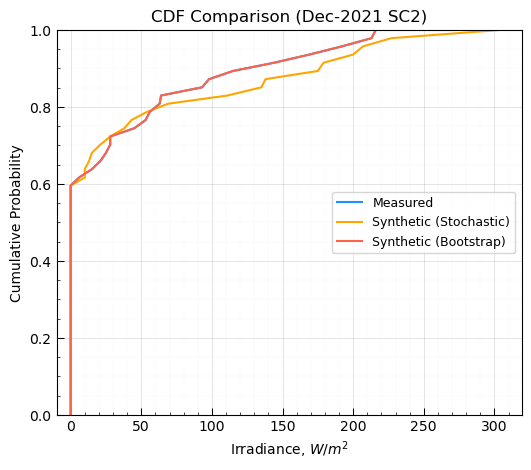

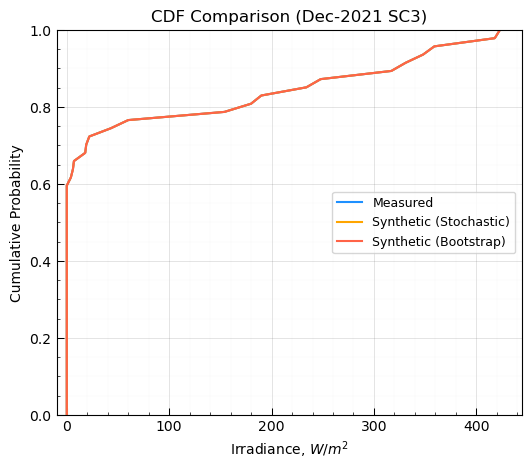

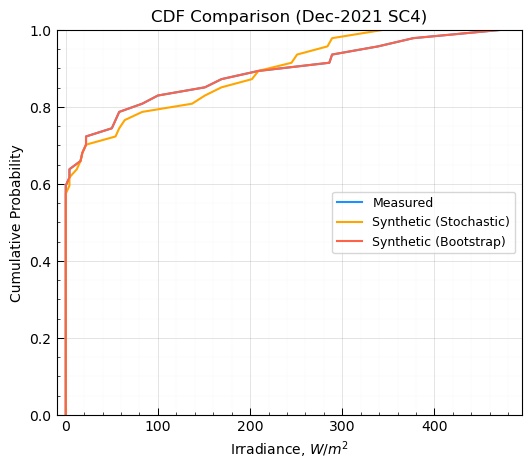

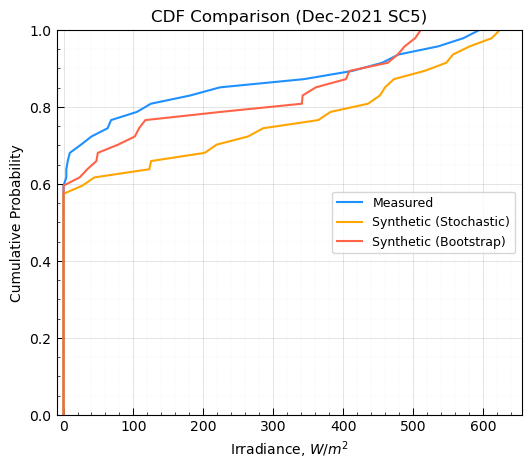

In [34]:
YY = 2021
MM = 'Dec'

for i in LOOP_SC[1::]:
    x, y = src.utils.cdf(data=LOOP_ANALYSIS[f'{MM}{YY}']['bootstrap'][i].T.sample(n=1, axis=1).iloc[:,0].values)
    xs, ys = src.utils.cdf(data=SYNTHETIC['stochastic'][f'{MM}{YY}-{i}'].sample(n=1, axis=1).iloc[:,0].values)
    xb, yb = src.utils.cdf(data=SYNTHETIC['bootstrap'][f'{MM}{YY}-{i}'].sample(n=1, axis=1).iloc[:,0].values)

    hor = 6
    ver = 5
    plt.figure(figsize=(hor,ver), dpi=100)

    plt.plot(x, y, color='dodgerblue', label='Measured')
    plt.plot(xs, ys, color='orange', label='Synthetic (Stochastic)')
    plt.plot(xb, yb, color='tomato', label='Synthetic (Bootstrap)')

    plt.title(f'CDF Comparison ({MM}-{YY} {str.upper(i)})')
    plt.ylabel('Cumulative Probability')
    plt.xlabel('Irradiance, $W/m^2$')
    plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
    plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
    plt.xticks(rotation=0)
    plt.minorticks_on()
    plt.ylim(0, 1)
    plt.xlim(-10, None)
    plt.grid(True)
    plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
    plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
    plt.tight_layout
    plt.legend(loc='center right', fontsize=9) # bbox_to_anchor=(1,1)